# Petals to the Metal - Flower Classification on TPU

# Introduction

The main goal is to build a machine learning classifier capable of identifying the type of flowers based on images. The dataset consists of images of 104 types of flowers, each labeled with its corresponding class.
The dataset contains imperfections, such as images of flowers in unusual settings or as backdrops to modern machinery. This introduces a level of difficulty, as the model needs to be robust enough to focus on the actual flowers in the images despite distractions. The performance of the machine learning models will likely be evaluated based on their macro F1 score in correctly classifying the flowers in the test set.

## Load and Import necessary libraries

In [1]:
import numpy as np 
import pandas as pd
import os
!pip install --upgrade tensorflow
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


2024-02-25 18:00:03.044434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 18:00:03.044485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 18:00:03.045840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [3]:
train_data_dir = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/train/"
test_data_dir = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/test/"
val_data_dir = "/kaggle/input/tpu-getting-started/tfrecords-jpeg-224x224/val/"

train_data = os.listdir(train_data_dir)
test_data = os.listdir(test_data_dir)
val_data = os.listdir(val_data_dir)
len(train_data)

16

In [4]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
        'class': tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)

    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)

    return image, example['class']

`parse_tfrecord_fn` function parses a single TFRecord example with image, ID, and class information. Decodes the JPEG image, resizes it to (224, 224) and returns the processed image and the class label.

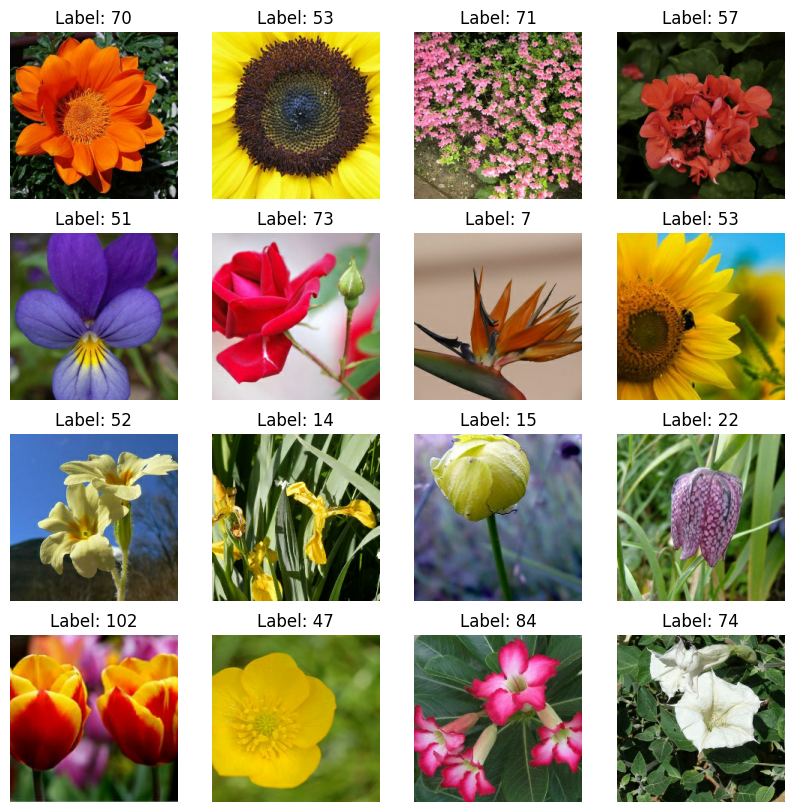

In [5]:
fig, axes = plt.subplots(4,4, figsize=(10,10))

for i, filename in enumerate(train_data):
    tfrecord_path = train_data_dir + '/' + filename
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    parsed_dataset = dataset.map(parse_tfrecord_fn)

    for j, (image, label) in enumerate(parsed_dataset.take(1)):
        pil_image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
        
        axes[i // 4, i % 4].imshow(pil_image)
        axes[i // 4, i % 4].set_title(f'Label: {label.numpy()}')
        axes[i // 4, i % 4].axis('off')

plt.show()

In [6]:
def load_your_data_function(data_dir,batch_size = 16):
    tfrecord_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    parsed_dataset = dataset.map(parse_tfrecord_fn)
    
    features = parsed_dataset.map(lambda x, y: x)
    labels = parsed_dataset.map(lambda x, y: y)
    
    dataset = tf.data.Dataset.zip((features, labels))
    dataset = dataset.batch(batch_size)
    
    return dataset
train = load_your_data_function(train_data_dir)
val = load_your_data_function(val_data_dir)

`load_your_data_function` function loads and preprocesses training and validation datasets from TFRecord files. Uses the parse_tfrecord_fn for parsing and batches the dataset based on the specified batch size.

In [7]:
def parse_test_tfrecord_fn(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, feature_description)

    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, (224, 224))  # Resize the images to (224, 224)
    
    def decode_id(id_tensor):
        return id_tensor.numpy().decode("utf-8")

    return image, tf.py_function(decode_id, [example['id']], tf.string)


In [8]:
def load_test_data_function(data_dir,batch_size = 16):
    tfrecord_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir)]
    dataset = tf.data.TFRecordDataset(tfrecord_files)
    parsed_test_dataset = dataset.map(parse_test_tfrecord_fn)
    
    features = parsed_test_dataset.map(lambda x, y: x)
    labels = parsed_test_dataset.map(lambda x, y: y)
    
    dataset = tf.data.Dataset.zip((features, labels))
    dataset = dataset.batch(batch_size)
    
    return dataset
test = load_test_data_function(test_data_dir)

In [9]:
id_values = []

for _, ids in test:
    id_values.extend(ids.numpy().tolist())
    
id_values = [item.decode('utf-8') for item in id_values]
id_values[:10]

['59d1b6146',
 '48c96bd6b',
 '7b437ba4e',
 '1b7aef8e8',
 'd6143b4d4',
 '2f90dff16',
 '8e7173502',
 'ae62dc8b0',
 'a29fae12a',
 '5eabca233']

## Model Architecture

The model architecture consists of three convolutional layers with max-pooling, followed by a flattening layer, and two dense layers. The output layer has 104 units with softmax activation, indicating it's designed for a classification task with 104 classes. The model is compiled using the Adam optimizer and sparse categorical crossentropy loss.

In [10]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(104, activation='softmax') 
])


In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [13]:
model.fit(train, epochs=8, validation_data=val)

Epoch 1/8


I0000 00:00:1708884064.236956     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


798/798 [==============================] - 29s 31ms/step - loss: 7.3326 - sparse_categorical_accuracy: 0.0572 - val_loss: 4.1279 - val_sparse_categorical_accuracy: 0.0671
Epoch 2/8
798/798 [==============================] - 23s 29ms/step - loss: 3.9912 - sparse_categorical_accuracy: 0.0910 - val_loss: 4.1413 - val_sparse_categorical_accuracy: 0.0695
Epoch 3/8
798/798 [==============================] - 23s 29ms/step - loss: 3.5407 - sparse_categorical_accuracy: 0.1860 - val_loss: 4.4502 - val_sparse_categorical_accuracy: 0.0717
Epoch 4/8
798/798 [==============================] - 23s 29ms/step - loss: 3.3335 - sparse_categorical_accuracy: 0.2448 - val_loss: 4.6158 - val_sparse_categorical_accuracy: 0.0660
Epoch 5/8
798/798 [==============================] - 23s 29ms/step - loss: 3.0667 - sparse_categorical_accuracy: 0.2999 - val_loss: 5.3510 - val_sparse_categorical_accuracy: 0.0641
Epoch 6/8
798/798 [==============================] - 23s 29ms/step - loss: 2.9179 - sparse_categorical_ac

After defining the model, it is trained using the fit function on the provided training dataset (train) for 10 epochs with validation on another dataset (val). Training progress is printed for each epoch, including loss and accuracy metrics.

In [14]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, (224, 224))

    return image


Preprocessing function defines a preprocess_image function to normalize pixel values between 0 and 1 and resize images to (224, 224).

In [15]:
predictions = []

for image, label in test:
    preprocessed_image = preprocess_image(image)
    prediction = model.predict(preprocessed_image)
    predictions.append(prediction)

predictions = np.concatenate(predictions, axis=0)
batch_size = 16

last_batch_size = test.cardinality().numpy() % batch_size
if last_batch_size > 0:
    predictions = predictions[:-last_batch_size]

1/1 [==============================] - 0s 350ms/step


Concatenates the list of predictions into a numpy array, resulting in a 2D array with shape (7368, 104) representing the probability distribution across 104 classes for each image. Checks if the last batch size is less than the specified batch size (16 in this case) and removes any padding in that case.

In [16]:
predictions

array([[0.00039059, 0.00013657, 0.00374791, ..., 0.00019168, 0.02997892,
        0.00080604],
       [0.00042967, 0.00013562, 0.00383683, ..., 0.00019498, 0.02641677,
        0.00078526],
       [0.00042676, 0.00014146, 0.00372136, ..., 0.00019679, 0.02481274,
        0.00079783],
       ...,
       [0.00038539, 0.00013012, 0.00358567, ..., 0.00018803, 0.02465285,
        0.00073873],
       [0.00042787, 0.0001414 , 0.00371793, ..., 0.00019681, 0.02481679,
        0.00079908],
       [0.00040674, 0.00012582, 0.00347069, ..., 0.00018076, 0.02456103,
        0.00075452]], dtype=float32)

## Model using Pre-trained Model:

To compare with the current model, we can consider using a pre-trained deep learning model like ResNet50 or MobileNetV2. These models have been trained on large datasets like ImageNet and have learned meaningful features that can be beneficial for various image classification tasks.

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [18]:
base_model = MobileNetV2(input_shape = (224,224,3),include_top = False, weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

model2 = models.Sequential([base_model,
                          layers.GlobalAveragePooling2D(),
                          layers.Dense(128),
                          layers.BatchNormalization(),
                          layers.Activation('relu'),
                          layers.Dense(104,activation = 'softmax')])


model2.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = 'sparse_categorical_accuracy')
model2.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 128)               0 

In [19]:
model2.fit(train,epochs = 8, validation_data = val)

Epoch 1/8
798/798 [==============================] - 31s 32ms/step - loss: 3.4247 - sparse_categorical_accuracy: 0.2098 - val_loss: 3.0553 - val_sparse_categorical_accuracy: 0.2543
Epoch 2/8
798/798 [==============================] - 24s 30ms/step - loss: 2.6400 - sparse_categorical_accuracy: 0.3464 - val_loss: 2.8591 - val_sparse_categorical_accuracy: 0.2950
Epoch 3/8
798/798 [==============================] - 24s 30ms/step - loss: 2.2194 - sparse_categorical_accuracy: 0.4316 - val_loss: 2.8586 - val_sparse_categorical_accuracy: 0.3055
Epoch 4/8
798/798 [==============================] - 24s 30ms/step - loss: 1.8938 - sparse_categorical_accuracy: 0.5091 - val_loss: 2.9163 - val_sparse_categorical_accuracy: 0.2977
Epoch 5/8
798/798 [==============================] - 24s 30ms/step - loss: 1.6155 - sparse_categorical_accuracy: 0.5799 - val_loss: 2.9888 - val_sparse_categorical_accuracy: 0.3015
Epoch 6/8
798/798 [==============================] - 24s 30ms/step - loss: 1.3701 - sparse_cate

We can see that the accuracy is much more better than the regular model with no pretrained model or fine tuning. Pre-trained models often have specific preprocessing requirements. In the case of MobileNetV2, for proper preprocessing, preprocess_input from tf.keras.applications.mobilenet_v2 is used.

In [20]:
def preprocess_image2(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

predictions_2 = []

for image, label in test:
    preprocessed_image = preprocess_image2(image)
    prediction = model2.predict(preprocessed_image)
    predictions_2.append(prediction)

predictions_2 = np.concatenate(predictions_2, axis=0)

1/1 [==============================] - 1s 899ms/step


## Fine tuning using Learning Rate Scheduler

By experimenting with learning rate scheduling to adapt the learning rate during training, we can potentially improve convergence.

In [21]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [22]:
initial_rate = 0.001
lr_schedule = ExponentialDecay(initial_rate, decay_steps = 10, decay_rate = 0.5, staircase = True)
model2.compile(optimizer = Adam(learning_rate = lr_schedule),loss = 'sparse_categorical_crossentropy', metrics = 'sparse_categorical_accuracy')

In [23]:
model2.fit(train,epochs = 8, validation_data = val)

Epoch 1/8
798/798 [==============================] - 28s 31ms/step - loss: 0.9192 - sparse_categorical_accuracy: 0.7406 - val_loss: 3.1496 - val_sparse_categorical_accuracy: 0.3502
Epoch 2/8
798/798 [==============================] - 24s 30ms/step - loss: 0.8979 - sparse_categorical_accuracy: 0.7472 - val_loss: 3.1496 - val_sparse_categorical_accuracy: 0.3505
Epoch 3/8
798/798 [==============================] - 24s 30ms/step - loss: 0.8979 - sparse_categorical_accuracy: 0.7472 - val_loss: 3.1496 - val_sparse_categorical_accuracy: 0.3505
Epoch 4/8
798/798 [==============================] - 24s 30ms/step - loss: 0.8979 - sparse_categorical_accuracy: 0.7472 - val_loss: 3.1496 - val_sparse_categorical_accuracy: 0.3505
Epoch 5/8
798/798 [==============================] - 24s 29ms/step - loss: 0.8979 - sparse_categorical_accuracy: 0.7472 - val_loss: 3.1496 - val_sparse_categorical_accuracy: 0.3505
Epoch 6/8
798/798 [==============================] - 24s 29ms/step - loss: 0.8979 - sparse_cate

In [24]:
predictions_3 = []

for image, label in test:
    preprocessed_image = preprocess_image2(image)
    prediction = model2.predict(preprocessed_image)
    predictions_3.append(prediction)

predictions_3 = np.concatenate(predictions_3, axis=0)


1/1 [==============================] - 0s 23ms/step


In [25]:
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels_2 = np.argmax(predictions_2, axis=1)
predicted_labels_3 = np.argmax(predictions_3, axis=1)

## Results and Analysis

In [26]:
submission1 = pd.DataFrame({'id': id_values[:len(predicted_labels)], 'label': predicted_labels})
submission2 = pd.DataFrame({'id': id_values, 'label': predicted_labels_2})
submission3 = pd.DataFrame({'id': id_values, 'label': predicted_labels_3})

In [27]:
print(submission1['label'].unique())
print(submission2['label'].unique())
print(submission3['label'].unique())

[5]
[ 83   4  28  73  80 103   7  67 102  48  79  98  86  29  87  92  91  35
   5  49   2  90  96   1  56  75  16  81  43  93  46  77 101  53  25  21
  66  74   0  14  20  24  52  30 100  72  70  44  94  10  18  64  36  95
  37  17  12  78  15  76  41  62  50  51]
[ 83   4  28  73  80  48 102   7  67  79  90  86 103  35  49   5  29  87
   2   1  56  91  16  98  14  96  43  46  77  75  53  92   0  74  81  25
 101  21  52  36 100  10  72  20  93  24  15  66  18  50  78  94  41  62
  19  51  12  64]


In [28]:
if (len(submission1['label'].unique()) >= len(submission2['label'].unique())) and (len(submission1['label'].unique()) >= len(submission3['label'].unique())):
    submission1.to_csv('submission.csv', index = False)
elif (len(submission2['label'].unique()) >= len(submission1['label'].unique())) and (len(submission2['label'].unique()) >= len(submission3['label'].unique())):
    submission2.to_csv('submission.csv', index = False)
else:
    submission3.to_csv('submission.csv', index = False)

In my Analysis, the model workd for me is the model with pretrained MobileNet model. It has significantly inproved the accuracy of the model. Model with learning_rate scheduler was better than the regular model but could not reduce the losses. 

## Conclusion

The pretrained model with MobileNet significantly improved the performance of the model. Further enhancement can be done by fine-tuning with learning rates, batch sizes and freezing only some layers of pretrained model. 